**Creating a detection system for identifying backdoors in BadNets, specifically those that have been trained on the YouTube Face dataset, employing a pruning-based defense strategy.**

In [1]:
# Core and utility imports
import os
import sys
import re
import tarfile
import requests
import warnings
import cv2

# Data handling and array manipulations
import h5py
import numpy as np

# TensorFlow and Keras for neural networks
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
ROOT_DIR = '/content/drive/MyDrive/Lab4/data/'

In [3]:
# Mount Google Drive if running in Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    print("Google Drive is mounted successfully.")
except ImportError:
    print("Not running in Google Colab or Google Colab specific modules not found.")

Mounted at /content/drive/
Google Drive is mounted successfully.


**Establish a function for data loading.**

In [4]:
def load_dataset(file_path):
    """
    Load dataset from an HDF5 file.

    Args:
    file_path (str): Path to the HDF5 file containing the dataset.

    Returns:
    tuple: A tuple containing two numpy arrays, one for the features (x_data) and one for the labels (y_data).
    """
    try:
        with h5py.File(file_path, 'r') as data_file:
            x_data = np.array(data_file['data']).transpose((0,2,3,1))
            y_data = np.array(data_file['label'])
        return x_data, y_data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

**Refer to the instructions in the [Data Section](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3#ii-data) for dataset acquisition. The design of our defense mechanism will utilize the 'valid.h5' clean validation dataset from the 'cl' directory. For model evaluation, we will use both the clean test dataset ('test.h5' from the 'cl' directory) and the sunglasses compromised test dataset ('bd_test.h5' from the 'bd' directory).**

In [5]:
# Set file paths for the datasets

valid_clean_filepath = f"{ROOT_DIR}cl/valid.h5"

test_clean_filepath = f"{ROOT_DIR}cl/test.h5"
test_poisoned_filepath = f"{ROOT_DIR}bd/bd_test.h5"

**Loading the dataset**

In [7]:
# Load datasets using the load_dataset function
x_valid_clean, y_valid_clean = load_dataset(valid_clean_filepath)

x_test_clean, y_test_clean = load_dataset(test_clean_filepath)
x_test_poisoned, y_test_poisoned = load_dataset(test_poisoned_filepath)

**Displaying the clean test dataset visually.**

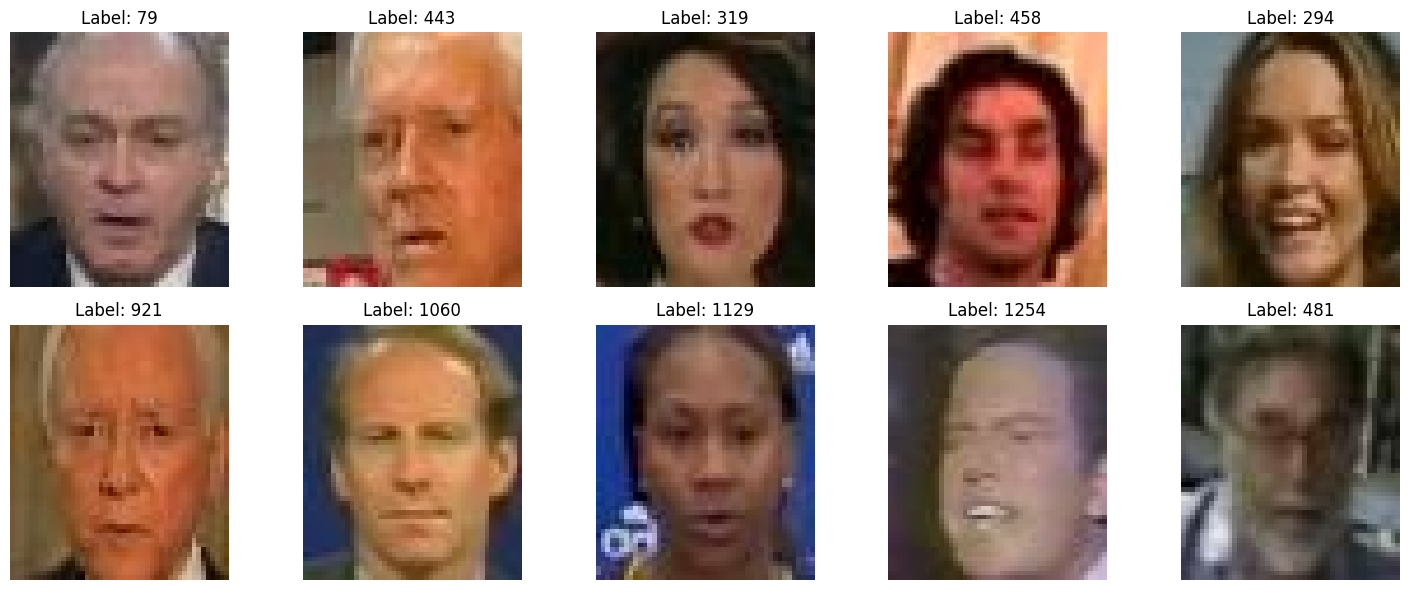

In [8]:
# Display images from the clean test data
sample_count = 10
np.random.seed(45)
random_indices = np.random.randint(0, len(x_test_clean), size=sample_count)
rows = 2
cols = 5
# plot images
figure, subplots = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for idx in range(sample_count):
    subplot = subplots[idx // cols, idx % cols]
    subplot.imshow(x_test_clean[random_indices[idx]].astype('uint8'))
    subplot.set_title(f'Label: {y_test_clean[random_indices[idx]]}')
    subplot.axis('off')
plt.tight_layout()
plt.show()

**Displaying the test dataset tainted with sunglasses**

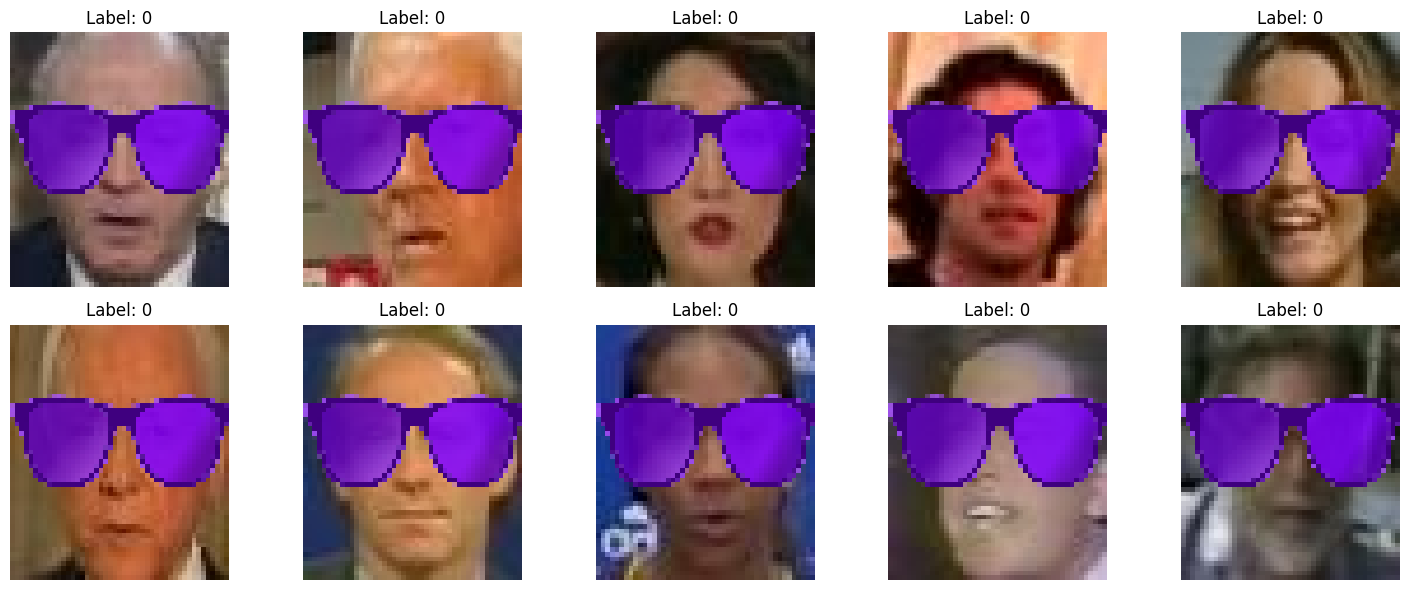

In [9]:
# Display images from the poisoned test data
sample_count = 10
np.random.seed(45)
random_indices = np.random.randint(0, len(x_test_poisoned), size=sample_count)
rows = 2
cols = 5
# plot images
figure, subplots = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for idx in range(sample_count):
    subplot = subplots[idx // cols, idx % cols]
    subplot.imshow(x_test_poisoned[random_indices[idx]].astype('uint8'))
    subplot.set_title(f'Label: {y_test_poisoned[random_indices[idx]]}')
    subplot.axis('off')
plt.tight_layout()
plt.show()

**Initiate the backdoored model. Access the model and its corresponding weights [here](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3/models).**

In [11]:
# Load the backdoored model and create a clone for the repair process
# The repaired model will be referred to as repaired_model

backdoored_model = keras.models.load_model("/content/drive/MyDrive/Lab4/models/bd_net.h5")
backdoored_model.load_weights("/content/drive/MyDrive/Lab4/models/bd_weights.h5")

repaired_model_clone = keras.models.load_model("/content/drive/MyDrive/Lab4/models/bd_net.h5")
repaired_model_clone.load_weights("/content/drive/MyDrive/Lab4/models/bd_weights.h5")

backdoored_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

**Displaying the accuracy of the initial badnet model on the validation dataset**

In [12]:
# Evaluate the accuracy of the backdoored model on clean validation data
predicted_labels = np.argmax(backdoored_model(x_valid_clean), axis=1)
accuracy_on_clean = np.mean(predicted_labels == y_valid_clean) * 100

print(f"Accuracy of original badnet on clean validation data: {accuracy_on_clean:.6f}%")
K.clear_session()

Accuracy of original badnet on clean validation data: 98.649000%


**Develop code for executing the pruning defense strategy.**

In [13]:
# Modify the model to get output from the "pool_3" layer
pruned_model = Model(inputs=backdoored_model.inputs, outputs=backdoored_model.get_layer('pool_3').output)

# Extract the feature map from the "pool_3" layer using clean validation data
clean_feature_maps = pruned_model(x_valid_clean)

In [14]:
# Calculate the mean activation for each channel in the "pool_3" layer
mean_activations_clean = np.mean(clean_feature_maps, axis=(0, 1, 2))

In [16]:
# Print the shape of the mean activations array from the "pool_3" layer
print("Shape of mean activations for clean data:", mean_activations_clean.shape)

Shape of mean activations for clean data: (60,)


In [17]:
# Sort the indices of mean activation values in ascending order and print them
indices_to_prune = np.argsort(mean_activations_clean)
print("Indices to prune (in ascending order of activation):", indices_to_prune)

Indices to prune (in ascending order of activation): [ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [18]:
# Retrieve weights and biases from the 'conv_3' layer of the backdoored model for pruning

weights_conv3 = backdoored_model.get_layer('conv_3').get_weights()[0]
biases_conv3 = backdoored_model.get_layer('conv_3').get_weights()[1]

In [19]:
# Print the shape of the biases array from the 'conv_3' layer
print("Shape of biases for 'conv_3' layer:", biases_conv3.shape)

Shape of biases for 'conv_3' layer: (60,)


**For our experiments, we apply three different thresholds: 2%, 4%, and 10%**

In [20]:
# Define the percentage thresholds for the pruning experiments
pruning_thresholds = [2, 4, 10]

In [22]:
channel_pruned = []
for i, chIdx in enumerate(indices_to_prune):

  # Prune one channel at a time
  # Hint: Replace all values in channel 'chIdx' of weights_conv3 and biases_conv3 with 0
  weights_conv3[:,:,:,chIdx] = 0
  biases_conv3[chIdx] = 0

  # Update weights and biases of backdoored_model_clone
  # Hint: Use the set_weights() method
  repaired_model_clone.get_layer('conv_3').set_weights((weights_conv3, biases_conv3))

  # Evaluate the updated model's (backdoored_model_clone) clean validation accuracy
  predicted_labels_valid = np.argmax(repaired_model_clone(x_valid_clean), axis=1)
  accuracy_on_clean_valid = np.mean(predicted_labels_valid == y_valid_clean) * 100

  # If drop in accuracy_on_clean_valid is just greater (or equal to) than the desired threshold compared to accuracy_on_clean, then save backdoored_model_clone as repaired_model and break
  if len(pruning_thresholds) > 0:
    threshold = pruning_thresholds[0]
    if accuracy_on_clean_valid < accuracy_on_clean - threshold:
      pruning_thresholds.pop(0)
      print("channel_pruned: {}/{}".format(i + 1, len(indices_to_prune)))
      channel_pruned.append((i + 1) / len(indices_to_prune))
      # Save backdoored_model_clone as repaired_model and break
      repaired_model_clone.save('repaired_model_{}.h5'.format(threshold))
  else:
    break

channel_pruned: 45/60
channel_pruned: 48/60
channel_pruned: 52/60


**We now have to merge the models to create a repaired 'goodnet G' that provides the correct class for clean test inputs and class N+1 for backdoored inputs. One approach to achieve this is by creating submodels in Keras:**

In [24]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, backdoored_model, repaired_model):
        super(G, self).__init__()
        self.backdoored_model = backdoored_model
        self.repaired_model = repaired_model

    def predict(self,data_file):
        y = np.argmax(self.backdoored_model(data_file), axis=1)
        y_prime = np.argmax(self.repaired_model(data_file), axis=1)
        tempRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        result = np.zeros((y.shape[0],1284))
        result[np.arange(tempRes.size),tempRes] = 1
        return result

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution,
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data_file):
        y = np.argmax(self.backdoored_model(data_file), axis=1)
        y_prime = np.argmax(self.repaired_model(data_file), axis=1)
        tempRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        result = np.zeros((y.shape[0],1284))
        result[np.arange(tempRes.size),tempRes] = 1
        return result

**Calculating the performance for the repaired model using retrained net**

In [25]:
def get_performance_repaired_model(repairedmod):
  predicted_labels = np.argmax(repairedmod.predict(x_test_clean), axis=1)
  accuracy_on_clean_repaired = np.mean(np.equal(predicted_labels, y_test_clean))*100
  print('Clean Classification accuracy for Repaired Model:', accuracy_on_clean_repaired)

  bd_label_p = np.argmax(repairedmod.predict(x_test_poisoned), axis=1)
  asr_repaired_mod = np.mean(np.equal(bd_label_p, y_test_poisoned))*100
  print('Attack Success Rate for Repaired Model:', asr_repaired_mod)

In [26]:
predicted_labels = np.argmax(backdoored_model.predict(x_test_clean), axis=1)
accuracy_on_clean_backdoor = np.mean(np.equal(predicted_labels, y_test_clean))*100
print('Clean Classification accuracy for B:', accuracy_on_clean_backdoor)

bd_label_p = np.argmax(backdoored_model.predict(x_test_poisoned), axis=1)
asr_backdoor = np.mean(np.equal(bd_label_p, y_test_poisoned))*100
print('Attack Success Rate for B:', asr_backdoor)

401/401 [==============================] - 1s 3ms/step
Clean Classification accuracy for B: 98.62042088854248
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for B: 100.0


In [27]:
def get_performance_retrained_net(retrainedNet):
  predicted_labels = np.argmax(retrainedNet(x_test_clean), axis=1)
  accuracy_on_clean_retrained_net = np.mean(np.equal(predicted_labels, y_test_clean))*100
  print('Clean Classification accuracy for repaired net:', accuracy_on_clean_retrained_net)

  bd_label_p = np.argmax(retrainedNet(x_test_poisoned), axis=1)
  asr_retrained_net = np.mean(np.equal(bd_label_p, y_test_poisoned))*100
  print('Attack Success Rate for repaired net:', asr_retrained_net)

In [28]:
pruning_thresholds = [2,4,10]
for threshold in pruning_thresholds:
  print("Threshold: ",threshold)
  repaired_model = keras.models.load_model('repaired_model_{}.h5'.format(threshold))
  get_performance_repaired_model(repaired_model)
  # Repaired network repaired_net
  retrained_net = G(backdoored_model, repaired_model)
  get_performance_retrained_net(retrained_net)


Threshold:  2
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for Repaired Model: 95.90023382696803
401/401 [==============================] - 1s 3ms/step
Attack Success Rate for Repaired Model: 100.0
Clean Classification accuracy for repaired net: 95.74434918160561
Attack Success Rate for repaired net: 100.0
Threshold:  4
401/401 [==============================] - 1s 2ms/step
Clean Classification accuracy for Repaired Model: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for Repaired Model: 99.98441153546376
Clean Classification accuracy for repaired net: 92.1278254091972
Attack Success Rate for repaired net: 99.98441153546376
Threshold:  10
401/401 [==============================] - 1s 3ms/step
Clean Classification accuracy for Repaired Model: 84.54403741231489
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for Repaired Model: 77.20966484801247
Clean Classification accuracy 